## Content <a id='content'></a>

[Introduction](#intro)

[Datasets](#datasets)

[Data preprocessing](#prep)

[Data Analysis](#da)

[Conclusions](#conclusions)

# Introduction <a id='intro'></a>

I am a team member for a big online store. Together with the marketing department, we compiled a list of hypotheses that may help boost revenue. I need to prioritize these hypotheses and then to analyze the results. 

**To prioritize the hypotheses, we will:**

- Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Show possible changes in the prioritization of hypotheses when applying RICE instead of ICE.

**To analyze the results, we will:**

- Graph and study cumulative revenue by group.
- Graph and study cumulative average order size by group.
- Graph and study the relative difference in cumulative average order size for group B compared with group A.
- Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot and study the daily conversion rates of the two groups and describe the difference.
- Plot and study a scatter chart of the number of orders per user.
- Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
- Plot and study a scatter chart of order prices.
- Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
- Find the statistical significance of the difference in conversion between the groups using the raw data
- Find the statistical significance of the difference in average order size between the groups using the raw data.
- Find the statistical significance of the difference in conversion between the groups using the filtered data.
- Find the statistical significance of the difference in average order size between the groups using the filtered data.

**Finally, we will make a decision based on the test results.** The possible decisions will be: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

# Datasets <a id='datasets'></a>

Data used in the first part of the project, prioritizing hypotheses, contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.

**hypotheses_us.csv**
- `Hypotheses` — brief descriptions of the hypotheses
- `Reach` — user reach, on a scale of one to ten
- `Impact` — impact on users, on a scale of one to ten
- `Confidence` — confidence in the hypothesis, on a scale of one to ten
- `Effort` — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

Data used in the second part of the project

**orders_us.csv**

- `transactionId` — order identifier
- `visitorId` — identifier of the user who placed the order
- `date` — of the order
- `revenue` — from the order
- `group` — the A/B test group that the user belongs to

**visits_us.csv**

- `date` — date
- `group` — A/B test group
- `visits` — the number of visits on the date specified in the A/B test group specified

# Data preprocessing <a id='prep'></a>

## Libraries

Let's load the libraries we might need:

In [1]:
# Loading the libraries

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns

from scipy import stats as st # We will need this in case we want to make some statistical checks
import math as mth

# To filter out automatic comments on plots from Jupyter (not affecting the output)
import warnings
warnings.filterwarnings("ignore") 

[Back to Content](#content)

## File upload

We will use a `load()` function to avoid potential problems with the file pathes.

In [2]:
# function `load` for a csv load with try-except and a number of rows limit
def load(filename, sep = ','):
    """
    i=In addition to the file name, the function takes nrow parameter
    for a particular number of rows to load. If None, then the file is loaded fully.
    """
    try:
        df_raw = pd.read_csv(filename, sep = sep)
    except:
        df_raw = pd.read_csv('/'+filename, sep = sep)
    return df_raw

In [3]:
hypotheses = load('datasets/hypotheses_us.csv')

In [4]:
orders_raw = load('datasets/orders_us.csv')

In [5]:
visits = load('datasets/visits_us.csv')

Let's look into the files:

In [6]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 1.4 KB


In [7]:
orders_raw.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3 KB


In [8]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 8.2 KB


We can note, that the `hypotheses_us.csv` has been read incorrectly, while `orders` and `visits` dataframes require some data types to be corrected; nevertheless, we will correct only the dates, since we need to be able to order by the `group` variable later on.

In [9]:
#orders_raw['group'] = orders_raw['group'].astype('category')

In [10]:
#visits['group'] = visits['group'].astype('category')

Let's check and fix date formats:

In [11]:
orders_raw.head(1)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B


In [12]:
orders_raw['date'] =  pd.to_datetime(orders_raw['date'], format="%Y-%m-%d")

In [13]:
visits.head(1)

,date,group,visits
0,2019-08-01,A,719


In [14]:
visits['date'] =  pd.to_datetime(visits['date'], format="%Y-%m-%d")

Let's give another try to `hypotheses_us.csv`:

In [15]:
hypotheses = load('datasets/hypotheses_us.csv', sep = ';')

In [16]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


Now the `hypotheses` dataframe is OK, we can fix the column names:

In [17]:
hypotheses.columns = [x.lower() for x in hypotheses.columns.to_list()]

In [18]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


No missing values revealed in either of the datasets.

[Back to Content](#content)

## Data overview <a id='data_overview'></a>

We start with the smallest dataframe:

In [19]:
pd.options.display.max_colwidth = 210

In [20]:
hypotheses

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [21]:
hypotheses['hypothesis'].to_list()

['Add two new channels for attracting traffic. This will bring 30% more users',
 'Launch your own delivery service. This will shorten delivery time',
 "Add product recommendation blocks to the store's site. This will increase conversion and average purchase size",
 'Change the category structure. This will increase conversion since users will find the products they want more quickly',
 'Change the background color on the main page. This will increase user engagement',
 'Add a customer review page. This will increase the number of orders',
 'Show banners with current offers and sales on the main page. This will boost conversion',
 'Add a subscription form to all the main pages. This will help you compile a mailing list',
 'Launch a promotion that gives users discounts on their birthdays']

One side observation can be made so far, besides the first one, the other hypotheses need more details to make them specific. Let's move to the `orders` dataframe.

In [22]:
orders_raw.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


In [23]:
visits.head(10)

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [24]:
print("Order time range:", orders_raw['date'].min(), orders_raw['date'].max())

Order time range: 2019-08-01 00:00:00 2019-08-31 00:00:00


In [25]:
print("Visit time range:", visits['date'].min(), visits['date'].max())

Visit time range: 2019-08-01 00:00:00 2019-08-31 00:00:00


The data covers one month, August  2019. Let's check the data for duplicates.

In [26]:
orders_raw['group'].unique()

array(['B', 'A'], dtype=object)

In [27]:
visits['group'].unique()

array(['A', 'B'], dtype=object)

In [28]:
len(visits)

62

Right, both dataframes have the visitors divided into two groups, `A` and `B`, the `visits` dataframe 62 entries accordingly.

[Back to Content](#content)

## Checking for duplicates <a id = "dup"> <a/>

First, we will make a basic technical check:

In [29]:
len(orders_raw)

1197

In [30]:
orders_raw[['visitorId']].nunique()

visitorId    1031
dtype: int64

We have 1031 unique visitor, some of the seem to make multiple orders during that month.

In [31]:
orders_raw.duplicated().sum()

0

No technical duplicates.

In [32]:
orders_raw[['transactionId', 'visitorId']].duplicated().sum()

0

In [33]:
orders_raw[['transactionId']].duplicated().sum()

0

In [34]:
orders_raw[['visitorId']].duplicated().sum()

166

Hm... No combination of transaction and visitor or transaction on its own are double counted, but there are duplicates for visitors. Some of them should be additional orders probably, but to be on the safe side, let's check that to visitorId can be find in both groups.

We will create the variables `ordersByUsersA` and `ordersByUsersB` to store the columns `['visitorId', 'orders']`. For users with at least one order, we will also indicate the number of orders made. 

In [35]:
ordersByUsersA = orders_raw[orders_raw['group']=='A'].groupby('visitorId',
                                                      as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders_raw[orders_raw['group']=='B'].groupby('visitorId',
                                                      as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [36]:
print(f"Total number of visitors in group A orders: {len(ordersByUsersA)}.")

Total number of visitors in group A orders: 503.


In [37]:
print(f"Total number of visitors in group B orders: {len(ordersByUsersB)}.")

Total number of visitors in group B orders: 586.


Let's check that no visiotr was not out into both groups.

In [38]:
# list of visitorId`s from group B orders
b_list = ordersByUsersB['visitorId'].to_list()
len(ordersByUsersA.query("visitorId in @b_list"))

58

In [39]:
# list of visitorId`s from group A orders
a_list = ordersByUsersA['visitorId'].to_list()
len(ordersByUsersB.query("visitorId in @a_list"))

58

We encounter 58 visitors whose id's are common for both groups. Let's single them out:

In [40]:
visitorId_dup = ordersByUsersB.query("visitorId in @a_list")['visitorId'].to_list()

In [41]:
#visitorId_dup

We have no option to know which group they could actually belong and we cannot just randomly distribute them by the groups; thus, we have no other option but delist them, even that they comprise 10% for `group B` and even more for `group A`. Actually, the next question is to which degree the data on visits is credible, since those visitors could be accounted twice as well... but we will have just to keep this consideration in mind. Let's "clean up" the `ordersByUsersA` and `ordersByUsersB` dataframes.

In [42]:
ordersByUsersA = ordersByUsersA.query('visitorId not in @b_list')

In [43]:
ordersByUsersB = ordersByUsersB.query('visitorId not in @a_list')

Let's check the final numbers.

In [44]:
len(ordersByUsersA)

445

In [45]:
len(ordersByUsersB)

528

Let's perform a preliminary check for outliers in the `orders` dataset.

In [46]:
orders_raw['revenue'].describe()

count     1197.000000
mean       131.491646
std        603.004729
min          5.000000
25%         20.800000
50%         50.200000
75%        130.400000
max      19920.400000
Name: revenue, dtype: float64

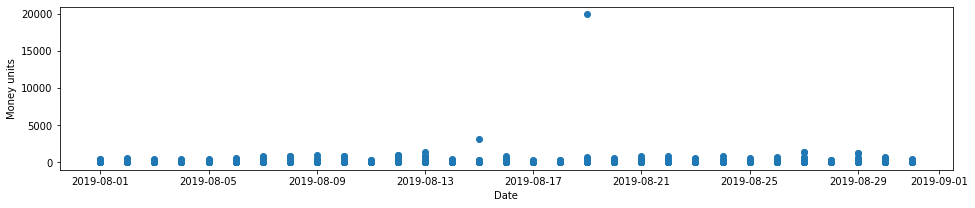

In [47]:
plt.figure(figsize=(16, 3))
plt.scatter(orders_raw['date'], orders_raw['revenue']) 
plt.ylabel("Money units")
plt.xlabel("Date")
plt.show()

We can already see that there is one order of 19920 (on August 19) money units and another one around 2500 (August 15); 75% of them are below 130.

In [48]:
ordersByUsersA['orders'].describe()

count    445.000000
mean       1.051685
std        0.267669
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

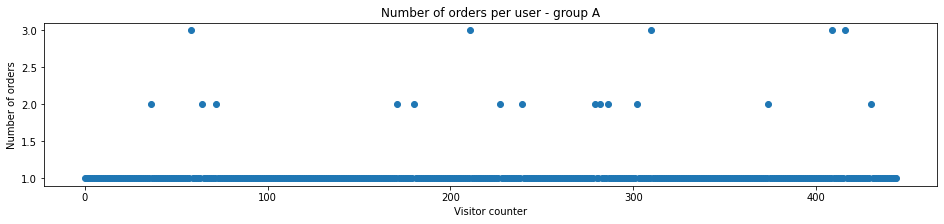

In [49]:
plt.figure(figsize=(16, 3))
x_values = pd.Series(range(0, len(ordersByUsersA['orders'])))
plt.scatter(x_values, ordersByUsersA['orders']) 
plt.ylabel("Number of orders")
plt.xlabel("Visitor counter")
plt.title("Number of orders per user - group A")
plt.show()

In [50]:
ordersByUsersB['orders'].describe()

count    528.000000
mean       1.037879
std        0.210008
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: orders, dtype: float64

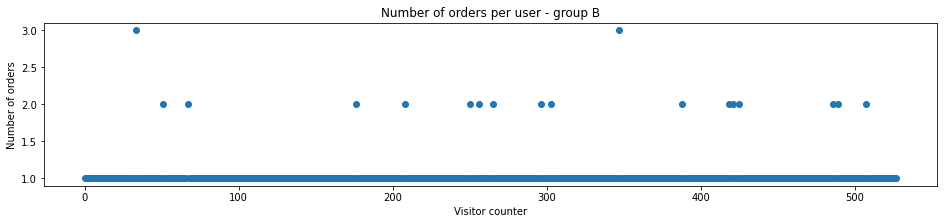

In [51]:
plt.figure(figsize=(16, 3))
x_values = pd.Series(range(0, len(ordersByUsersB['orders'])))
plt.scatter(x_values, ordersByUsersB['orders']) 
plt.ylabel("Number of orders")
plt.xlabel("Visitor counter")
plt.title("Number of orders per user - group B")
plt.show()

With regard to the number of orders per visitor, there are 5 visiotrs with 3 orders, and about 10 visitors with 2 orders; 75% of them placed only one order.

### Summary on datasets

1. A quick check of the necessary data types was performed, date and category data types were fixed.
2. No missing values.
3. The resulting datasets contain data on 1031 visitors and 1197 orders, but we have found that 58 visitors were double counted (see below).
4. The observations cover one month, August 2019.
5. In the initial `orders` dataframe, we saw that there was one order of 19920 money units and another one around 2500; 75% of them are below 130.
6. We encounter 58 visitors whose id's are common for both groups. We had no option rather than delist them, even that they comprise 10% for `group B` and even more for `group A`. We will keep in mind, that the data on visits should have been also checked by the source, since those visitors could be accounted twice as well.
7. After recalculating the `ordersByUsersA` and `ordersByUsersB` dataframes, there are 7 visitors left with 3 orders, and about 20 visitors with 2 orders; 75% of them placed only one order.

[Back to Content](#content)

Let's move on with the analysis.

# Data Analysis <a id='da'></a>

### Part 1. Prioritizing Hypotheses

Let's apply the `ICE` framework to prioritize hypotheses. Sort them in descending order of priority.

ICE has three components:

- Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product
- Confidence — how sure you are that your product will affect them in this way
- Effort — how much will it cost to test the hypothesis.

In [52]:
hypotheses['ICE'] = hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']

hypotheses[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


Let's apply the `RICE` framework to prioritize hypotheses. Sort them in descending order of priority.

RICE has four components:

- Reach — how many users will be affected by the update you want to introduce
- Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product
- Confidence — how sure you are that your product will affect them in this way
- Effort — how much will it cost to test the hypothesis.

In [53]:
hypotheses['RICE'] = hypotheses['reach']*hypotheses['impact']*hypotheses['confidence']/hypotheses['effort']

hypotheses[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False)

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


Let's analyze how the prioritization of hypotheses changes when you use `RICE` instead of `ICE` and find possible explanation.

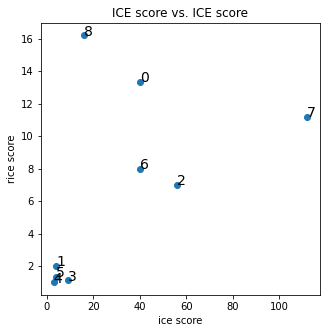

In [54]:
plt.figure(figsize=(5, 5))

x_= hypotheses['RICE']
y_ = hypotheses['ICE']
annotations = hypotheses.index.to_list()

plt.scatter(x_,y_) 
plt.ylabel("rice score")
plt.xlabel("ice score")
plt.title("ICE score vs. ICE score")


for i, label in enumerate(annotations):
    plt.annotate(label, (x_[i], y_[i]), fontsize = 14)

plt.show()

While the TOP5 hypotheses in both cases are the same, with both methods we have hypothesis `7` and `0` in the TOP3 and hypothesis `6` on the 4th place; one striking difference is that hypothesis `2` takes the second place with `RICE` (only the 5th witn `ICE`), while hypothesis `8` gives the same result with `ICE`. The only difference is that in `RICE` the `reach` factor is taken into account, the estimate of  how many users will be affected by the update. Anyway, drawing upon the two results, we could recommend re-check the scores and to recalculate the ratings. While waiting for the ambiguity to be resolved, we would say that `7` seems to be the most prominent hypothesis to be of the top p
riority.

[Back to Content](#content)

### Part 2. A/B Test Analysis

#### Let's graph and study cumulative revenue by group.

We'll build an array with unique paired date-group values using the `drop_duplicates()` method and before that we will clean up the `order` dataframe from the duplicated `visitorId`'s:

In [55]:
orders = orders_raw.query('visitorId not in @visitorId_dup')

In [56]:
len(orders)

1016

We are left with 181 order less than initially.

In [57]:
# building an array with unique paired date-group values 
datesGroups = orders[['date','group']].drop_duplicates()

To collect the aggregated cumulative daily data on orders, we:

1. get the rows of the `orders` table where the date is less than or equal to the date of the `datesGroups` element and the test group is the same as in `datesGroups`;

2. aggregate the values. We find the maximum date. We'll find the maximum value for the group, too, so that we have the `group` column in our final output. We find the number of unique order and user IDs and calculate the sum of average purchase sizes;

3. apply the methods to each row of the DataFrame (`apply(axix=1)`) and sort the results by the columns `date` and `group`:

In [58]:
# getting aggregated cumulative daily data on orders
ordersAggregated = datesGroups.apply(lambda x:
                                     orders[np.logical_and(orders['date'] <= x['date'],
                                     orders['group'] == x['group'])].agg({'date' : 'max',
                                                                          'group' : 'max',
                                                                          'transactionId' : pd.Series.nunique,
                                                                          'visitorId' : pd.Series.nunique,
                                                                          'revenue' : 'sum'}),
                                     axis=1).sort_values(by=['date','group'])

Let's do something similar to get the aggregated cumulative daily data on visitors:

In [59]:
# getting aggregated cumulative daily data on visitors  
visitorsAggregated = datesGroups.apply(lambda x:
                                       visits[np.logical_and(visits['date'] <= x['date'],
                                       visits['group'] == x['group'])].agg({'date' : 'max',
                                                                              'group' : 'max',
                                                                              'visits' : 'sum'}),
                                       axis=1).sort_values(by=['date','group'])

We merge the two tables into one and give its columns descriptive names:

In [60]:
# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


Let's plot cumulative revenue graphs by day and A/B test group:

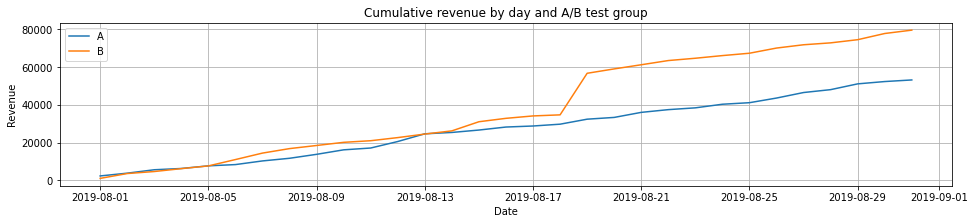

In [61]:
# DataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A revenue graph 
plt.figure(figsize=(16, 3))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.grid()

plt.ylabel("Revenue")
plt.xlabel("Date")
plt.title("Cumulative revenue by day and A/B test group")

plt.xticks(rotation = 0)

plt.legend()
plt.show()

Revenue is rising steadily throughout the whole test. We can see that group B experiences a lighter spike on August 16 and a heavier spike in revenue on August 19 (from the previous investigation, we know that two very expensive orders were placed on those dates).

#### Let's graph and study cumulative average order size by group. <a id = "outliers"> <a/>

To plot average purchase size by group, we will divide cumulative revenue by the cumulative number of orders:

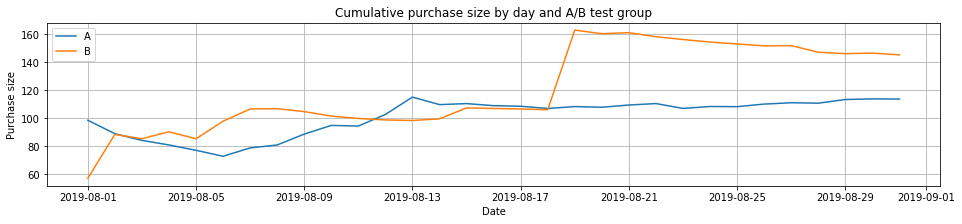

In [62]:
plt.figure(figsize=(16, 3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.grid()

plt.ylabel("Purchase size")
plt.xlabel("Date")
plt.title("Cumulative purchase size by day and A/B test group")

plt.legend()
plt.show()

Average purchase size becomes steady by the end of the test, although the result is ambiguous. The surge in group `B` is due to the presence of relatively expensive orders. We have to clean them up. 

#### Removing the abnormal user data

Now, we will find the total number of anomalous users using the `shape()` method; we will assume that anomalous means more than 4 orders and orders with the revenue higher that 1221 money unit.

Let's get back to the scatter chart of the number of orders per user.

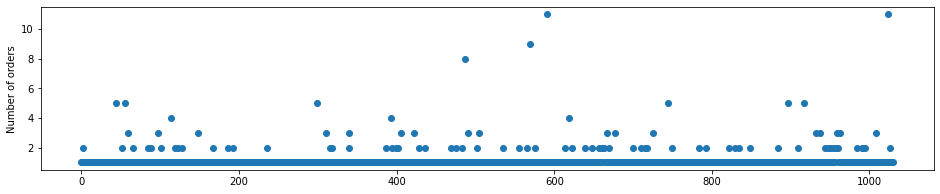

In [63]:
plt.figure(figsize=(16, 3))
ordersByUsers = orders_raw.groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers['orders'])))

plt.scatter(x_values, ordersByUsers['orders']) 

plt.ylabel("Number of orders")
plt.xlabel("")
plt.show()

Let's calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [64]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Less than 1% of the visitors placed more than 4 orders.

Let's plot and study a scatter chart of order prices.

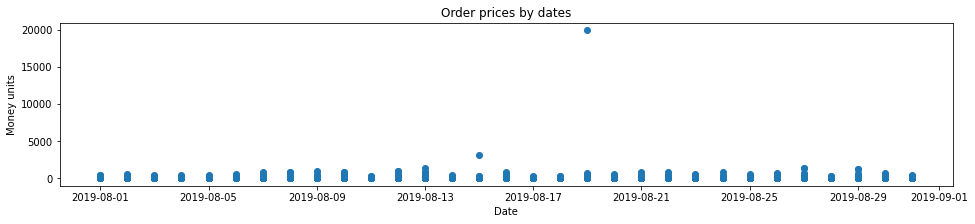

In [65]:
plt.figure(figsize=(16, 3))
plt.scatter(orders_raw['date'], orders_raw['revenue']) 
plt.ylabel("Money units")
plt.xlabel("Date")
plt.title("Order prices by dates")
plt.show()

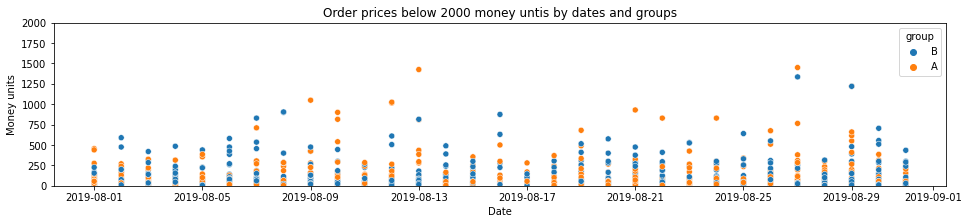

In [66]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data = orders_raw, x = 'date', y = 'revenue', hue = 'group') 

plt.ylim(0,2000)

plt.ylabel("Money units")
plt.xlabel("Date")
plt.title("Order prices below 2000 money untis by dates and groups")

plt.show()

<div class="alert alert-info"> <b>Studen comment: </b> Great, thanks for the tip!</div>  

Let's calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [67]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[280.8   414.275 830.3  ]


Less than 1% of the visitors placed orderes with a price tag higher than 830 money units.

Users who place many orders or high price orders inflate the estimates. Their behavior probably differs from the normal pattern. Typically, users should place no more than two orders within such a short period of time as one month.

In [68]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 4]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 4]['visitorId']], axis = 0)

usersWithExpensiveOrders = orders[orders['revenue'] > 830]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders],
                          axis = 0).drop_duplicates().sort_values()

abnormalUsers

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
425     1920142716
1196    2108080724
287     2254456485
131     2254586615
613     3931967268
940     4003628586
743     4133034833
Name: visitorId, dtype: int64

We have 12 visitors of this kind. Let's take a look at how many orders we are talking about:

In [69]:
len(orders_raw.query('visitorId in @abnormalUsers'))

12

Those 12 visitors placed one order each. Let's see what is the maximum `revenue` for these 41 order:

In [70]:
orders_raw.query('visitorId in @abnormalUsers')['revenue'].describe()


count       12.000000
mean      2768.358333
std       5438.488971
min        830.300000
25%        886.925000
50%       1020.850000
75%       1358.150000
max      19920.400000
Name: revenue, dtype: float64

Let's see what group do these visitors belong to.

In [71]:
orders_raw.query('visitorId in @abnormalUsers')['group'].value_counts()

A    7
B    5
Name: group, dtype: int64

Those are visitors from both of the groups. Let's remove them as well and plot the cumulative graphs once again.

In [72]:
orders = orders_raw.query('visitorId not in @abnormalUsers')
datesGroups = orders[['date','group']].drop_duplicates()

# getting aggregated cumulative daily data on orders
ordersAggregated = datesGroups.apply(lambda x:
                                     orders[np.logical_and(orders['date'] <= x['date'],
                                     orders['group'] == x['group'])].agg({'date' : 'max',
                                                                          'group' : 'max',
                                                                          'transactionId' : pd.Series.nunique,
                                                                          'visitorId' : pd.Series.nunique,
                                                                          'revenue' : 'sum'}),
                                     axis=1).sort_values(by=['date','group'])

# getting aggregated cumulative daily data on visitors  
visitorsAggregated = datesGroups.apply(lambda x:
                                       visits[np.logical_and(visits['date'] <= x['date'],
                                       visits['group'] == x['group'])].agg({'date' : 'max',
                                                                              'group' : 'max',
                                                                              'visits' : 'sum'}),
                                       axis=1).sort_values(by=['date','group'])

# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,21,20,1620.0,713
2,2019-08-02,A,44,38,3860.3,1338
3,2019-08-02,B,45,43,4243.8,1294
4,2019-08-03,A,68,62,5675.5,1845


Let's plot cumulative the graphs:

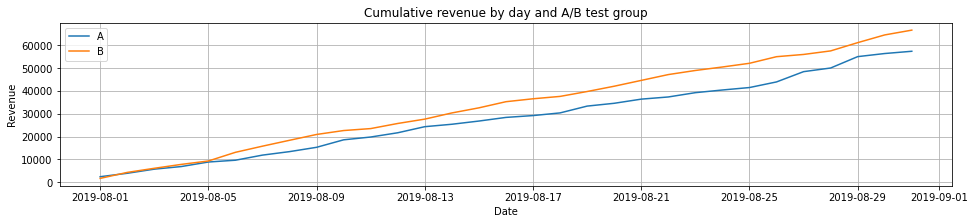

In [73]:
# DataFrame with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A revenue graph 
plt.figure(figsize=(16, 3))

plt.grid()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.ylabel("Revenue")
plt.xlabel("Date")
plt.title("Cumulative revenue by day and A/B test group")

plt.legend()
plt.show()

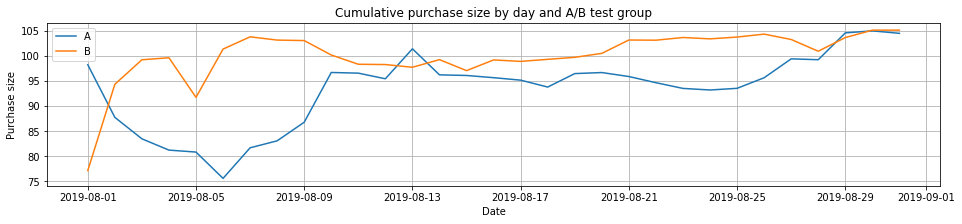

In [74]:
plt.figure(figsize=(16, 3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.grid()

plt.ylabel("Purchase size")
plt.xlabel("Date")
plt.title("Cumulative purchase size by day and A/B test group")

plt.legend()
plt.show()

Great, now the graphs make more sense. The cumulative revenue is steadily higher for group `B` than for group `A`. The cumulative average purchase size fluctuated for group `A` and was more stable for group `B`; by the end of the test, they converged.

#### Let's analyze the cumulative conversion graph

We will calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot and study the daily conversion rates of the two groups and describe the difference.

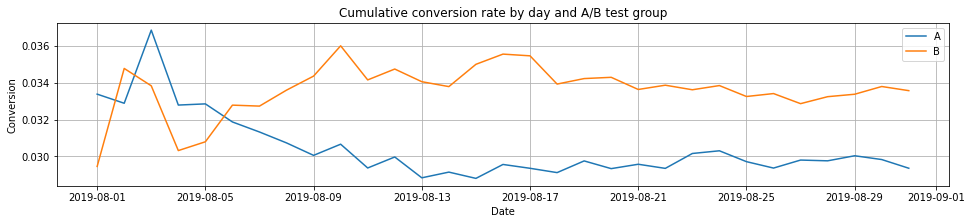

In [75]:
# calculating cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting the graphs
plt.figure(figsize=(16, 3))

plt.grid()

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.ylabel("Conversion")
plt.xlabel("Date")
plt.title("Cumulative conversion rate by day and A/B test group")

plt.show()

At the beginning of the test, group `B` was lagging behind, but then it took the lead. Both groups started showing the signs of some steady difference by the end of the test. Let's look into it.


To plot a relative difference graph, we will add a horizontal axis with the `axhline()` method (i.e. horizontal line across the axis):

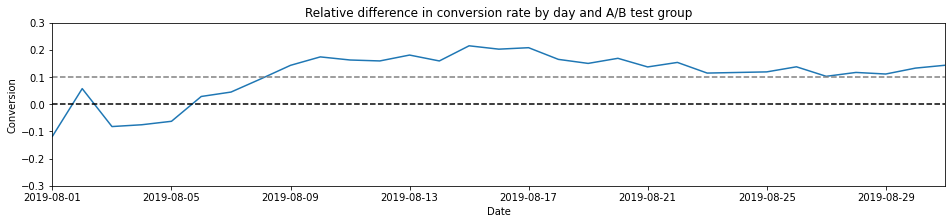

In [76]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16, 3))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
#plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d').date(),
          dt.datetime.strptime('2019-08-31', '%Y-%m-%d').date(),
          -0.3, 0.3])

plt.ylabel("Conversion")
plt.xlabel("Date")
plt.title("Relative difference in conversion rate by day and A/B test group")

plt.show()

In general, the conversion ratio became stable and group `B` had at least 10% higher relative conversion rate compared to group `A`.

#### Let's graph and study the relative difference in cumulative average order size for group B compared with group A.


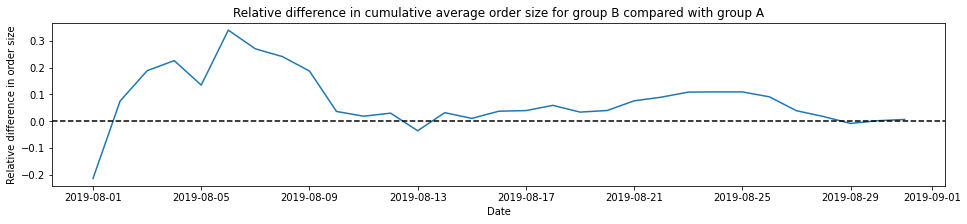

In [77]:
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.figure(figsize=(16, 3))

plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')

plt.ylabel("Relative difference in order size")
plt.xlabel("Date")
plt.title("Relative difference in cumulative average order size for group B compared with group A")

plt.show()

Although, there had been some difference, it turned to be near-zero by the end of the test.

Thus, we can move to hypothesis testing, let's elaborate a bit on what method we will use to this purpose.

### On testing the hypothesis of different ditributions with the Wilcoxon-Mann-Whitney Nonparametric Test

In what follows, we will employ the Wilcoxon-Mann-Whitney Nonparametric Test to test the hypothesis of difference beetween distributions.

Nonparametric methods, in general, do not make assumptions about how the data is distributed, so one does not have to estimate the distribution's parameters (parametric methods use a sample to evaluate the parameters of the expected distribution, for example, the mean). These methods are used when hypotheses of normality are not relevant. 

#### Let's find the statistical significance of the difference in conversion between the groups using the raw data (with filtered duplicated `visitorId`'s)

Here we will calculate the statistical significance of the differences in conversion between the groups, using unfiltered data. First we will recalculate the samples of the number of orders per user for each test group:

In [78]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId',
                                                      as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId',
                                                      as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

Now we'll declare the variables `sampleA` and `sampleB`, with users from different groups and corresponding numbers of orders. Those who didn't order anything will have `0`. This is necessary to prepare the samples for the Mann-Whitney test. 

In [79]:
sampleA = pd.concat([ordersByUsersA['orders'],
                    pd.Series(0,index=np.arange(visits[visits['group']=='A']['visits'].sum()
                                                    - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                    pd.Series(0,index=np.arange(visits[visits['group']=='B']['visits'].sum()
                                                    - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Now, let's formulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of conversion rates between the two groups.
2. Alternative hypothesis: the distribution of conversion rates are different.
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

We'll apply the criterion and format the p-value by rounding it to three decimal places. 

In [80]:
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

0.014


Let's print the relative conversion gain for group B: `group B conversion` / `group A conversion` - 1.  Each of the last two dataframes stores a sample where each element is the number of orders made by a certain user, including zeroes. So the number of `sampleA` elements is the number of users, and the sum of all the elements is the number of orders. To get the group's conversion rate, we'll need to divide the sum of the orders by the number of users. Using the `mean()` method, we'll find the mean for `sampleA`. We'll find the conversion rate for group B in a similar way: `sampleB.mean()`.

In [81]:
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

0.144


The first row of the output gives us the p-value, 0.014, which is less than 0.05. So we can reject the null hypothesis that there is statistically insignificant difference in conversion between the groups. The relative gain of group B is 14.4% (the second row of the output). Let's test the hypothesis that the second dataset is greater and the first one smaller.

To test a one-sided (unilateral) hypothesis, we have to pass another two parameters to the method: the boolean type and defines whether you should correct for the continuity of the distribution that's used to describe discrete data in the test and a string: 'less', 'two-sided', or 'greater'. If the string parameter is employed, the boolean parameter needs to be True. Thus, to compare the first dataset passed to the method is less than the second one, we will set the parameter as 'less'.

Let's reformulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of conversion rates between the two groups.
2. Alternative hypothesis: the first dataset (`A`) "is less" than the second one (`B`).
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

In [82]:
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB, True, 'less')[1]))

0.007


The p-value is even smaller than in the case of two-sided test, thus we can reject the null hypothesis and conclude that the conversion rate for group `B` is higher than for group `A`.

#### Let's find the statistical significance of the difference in average order size between the groups using the raw data (with filtered `visitorId`'s duplicates)

Now, let's formulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of the order size between the two groups.
2. Alternative hypothesis: the distribution of the order size are different.
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

We will perform the same calculations for the revenue and calculate the statistical significance of the difference in the segments' average order size:

In [83]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                       /orders[orders['group']=='A']['revenue'].mean()-1))

0.585
0.006


The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that average order size differs between the groups. The average order size for group B looks the same as for group A. 

#### Let's find the statistical significance of the difference in conversion between the groups using the filtered data.

Now, let's formulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of conversion rates between the two groups.
2. Alternative hypothesis: the distribution of conversion rates are different.
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

In [84]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum()
                                 - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
    pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum()
                                 - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [85]:
print("{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'less')[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.007
0.144


The results for the conversion rates didn't change.

#### Let's find the statistical significance of the difference in average order size between the groups using the filtered data.

Now, let's formulate the null and the alternative hypotheses for testing:
1. The null hypothesis: there is no difference in the distributions of the order size between the two groups.
2. Alternative hypothesis: the distribution of the order size are different.
3. p-value: 0.05. We will reject the null hypothesis if the p-value is higher.

In [86]:
print('{0:.3f}'.format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',
    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.585
0.006


The general conclusion on the significance of the difference in average order size didn't change at all. 

[Back to Content](#content)

**Conclusions on the results of the A/B testing:**


- Both raw and filtered data revealed statistically significant differences in conversion between the groups.
- The graph showing the difference in conversion tells that, by the end of the month, group `B` demonstarted higher relative gain of 15%:

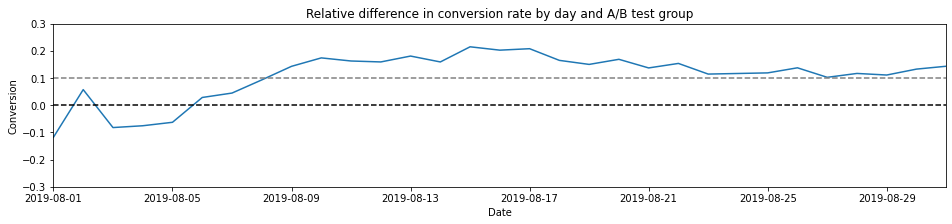


- Neither raw nor filtered data revealed any statistically significant differences in order size ('revenue') between the groups.
- The graph showing the difference in average order size between the groups tells that it can be too early to make conclusions:

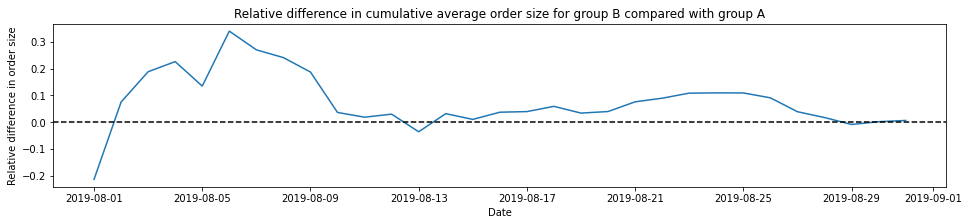

Based on these facts and given the goal of the project, to reveal a hypothesis that may help boost revenue, we can conclude that the test should be continued until the more steady graph of the average order size for the two groups is achieved as well.

# Conclusions <a id='conclusions'></a>

Together with the marketing department, we compiled a list of hypotheses that may help boost revenue. As a data analyst, my first task was to prioritize the hypotheses and then analyze the results of corresponding A/B test.

We have uploaded and preprocessed the data. The most significant observation at this step were [58 visitors](#dup) who ended up being assigned to both `A` and `B` group. We had no other option rather than to drop their entries all together.

We employed two methods, `ICE` and `RICE` to prioritize hypotheses. While the TOP5 hypotheses in both cases are the same, with both methods we have hypothesis `7` and `0` in the TOP3 and hypothesis `6` on the 4th place; one striking difference is that hypothesis `2` takes the second place with `RICE` (only the 5th witn `ICE`), while hypothesis `8` gives the same result with `ICE`. The only difference is that in `RICE` the `reach` factor is taken into account, the estimate of  how many users will be affected by the update. Anyway, drawing upon the two results, we could recommend re-check the scores and to recalculate the ratings. While waiting for the ambiguity to be resolved, we would say that `7` seemed to be the most prominent hypothesis to be of the top priority.

After plotting the cumulation revenue and average order size, we quickly discovered the [outliers](#outliers), which we had to drop as well to be able to make sense of the data at hand.

Then, we analyzed the difference in conversion rates and the difference in order size for the two groups and used non-parametric method to test the hypoteses about the significance of those differences. We conducted the tests both on the raw data (without duplicates) and on the filtered data. Both raw and filtered data revealed statistically significant differences in conversion between the groups. By the end of the month, group `B` demonstarted 14.4% higher relative gain.

Neither raw nor filtered data revealed any statistically significant differences in the order size (`revenue`) distributions of the groups; although the graph showing the difference in average order size between the groups tells that it can be too early to make conclusions.

Based on these facts and given the goal of the project, to reveal a hypothesis that may help boost the total revenue, we can conclude that the given A/B test delivered prominent results on the conversion rates, but it should be continued until the more steady graph of the average order size for the two groups is achieved as well.